# Blurring(Gaussiann) Filter Exp for Large objects

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import requests
from PIL import Image
import cv2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img

def plotAndSaveOriginGaussianResult(model=None, image_url=None, save_number=None, kernel_size=None, sigma=None):
    # model
    img = np.array(Image.open(requests.get(image_url, stream=True).raw))
    img = cv2.resize(img, (640, 640))
    rgb_img = img.copy()
    img = np.float32(img) / 255
    transform = transforms.ToTensor()
    
    model.eval()
    model.cpu()
    
    
    # original rgb_img forward
    results = model([rgb_img])
    boxes, colors, names = parse_detections(results)
    detections = draw_detections(boxes, colors, names, rgb_img.copy())
    Image.fromarray(detections)
    # save the original rgb_img forward result
    image = Image.fromarray(detections)
    image.save(f"./blurring_sharpening_filters/{save_number}_origin.png")
    
    # gaussian filtered rgb_img forward
    rgb_tensor = torch.from_numpy(rgb_img)
    gaussian_teacher = transforms.GaussianBlur(kernel_size=kernel_size, sigma=sigma)
    gaussian_rgb_tensor = gaussian_teacher(rgb_tensor)
    gaussian_rgb_img = gaussian_rgb_tensor.numpy()
    # gaussian_rgb_img += rgb_tensor.numpy()
    results_gaussian = model([gaussian_rgb_img])
    boxes, colors, names = parse_detections(results_gaussian)
    detections = draw_detections(boxes, colors, names, rgb_img.copy())
    Image.fromarray(detections)
    # save the gaussian filtered rgb_img forward result
    image = Image.fromarray(detections)
    sigma = str(sigma).replace(".", "")[5]
    image.save(f"./blurring_sharpening_filters/{save_number}_gaussian_k{kernel_size}_s{sigma}.jpg")

In [3]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

url_list = [
    "http://farm8.staticflickr.com/7218/7048835433_97d58c41dd_z.jpg",
    "http://farm8.staticflickr.com/7069/7144544497_4ce8268017_z.jpg",
    "http://farm9.staticflickr.com/8331/8395076888_929af4a595_z.jpg",
    "http://farm8.staticflickr.com/7216/7398739548_991338f382_z.jpg",
    "http://farm1.staticflickr.com/48/131364607_433f149962_z.jpg",
    "http://farm1.staticflickr.com/91/239378460_3fc1f9a101_z.jpg",
]

for i, url in enumerate(url_list):
    plotAndSaveOriginGaussianResult(model=model, image_url=url, save_number=i, kernel_size=3, sigma=(0.1, 1.0))
    plotAndSaveOriginGaussianResult(model=model, image_url=url, save_number=i, kernel_size=3, sigma=(0.1, 2.0))
    plotAndSaveOriginGaussianResult(model=model, image_url=url, save_number=i, kernel_size=3, sigma=(0.1, 3.0))
    plotAndSaveOriginGaussianResult(model=model, image_url=url, save_number=i, kernel_size=5, sigma=(0.1, 2.0))
    print(f"image {i} done")

Using cache found in /home/hslee/.cache/torch/hub/ultralytics_yolov5_master


WARNING ⚠️ Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
View settings with 'yolo settings' or at '/home/hslee/.config/Ultralytics/settings.yaml'
Update settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
requirements: Ultralytics requirement ['gitpython>=3.1.30'] not found, attempting AutoUpdate...
requirements: ❌ AutoUpdate skipped (offline)


YOLOv5 🚀 2024-8-31 Python-3.11.0 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24145MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


image 0 done
image 1 done
image 2 done
image 3 done
image 4 done
image 5 done


# plot original image

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# Step 1: Get the image from the URL
img_url = "http://farm8.staticflickr.com/7218/7048835433_97d58c41dd_z.jpg"
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))

# Step 2: Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Blurring(Gaussian) Filtered image

In [6]:
import torchvision.transforms as transforms

img_url = "http://farm8.staticflickr.com/7218/7048835433_97d58c41dd_z.jpg"
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))

gaussian_filter = transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
img_gaussian = gaussian_filter(img)
plt.imshow(img_gaussian)
plt.axis('off')
plt.show()

gaussian_filter = transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 2.0))
img_gaussian = gaussian_filter(img)
plt.imshow(img_gaussian)
plt.axis('off')
plt.show()

# Sharpening Filter

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Get the image from the URL
img_url = "http://farm8.staticflickr.com/7218/7048835433_97d58c41dd_z.jpg"
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))

# black and white
img = img.convert('L')

# Step 2: Display the image
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [8]:
# Canny filter

import cv2

# Step 1: Get the image from the URL
img_url = "http://farm8.staticflickr.com/7218/7048835433_97d58c41dd_z.jpg"
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))

# black and white
img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
print(f"data type: {img.dtype}, shape: {img.shape}")
canny_filter = cv2.Canny(img, 100, 200)

temp = img.copy()
img += canny_filter # local feature enhancement
img = img - temp

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()


data type: uint8, shape: (424, 640)


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import requests
from PIL import Image
import cv2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [10]:

COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img

def plotAndSaveCannyResult(model=None, image_url=None, save_number=None, kernel_size=None, sigma=None):
    # model
    img = np.array(Image.open(requests.get(image_url, stream=True).raw))
    print(img.shape)
    img = cv2.resize(img, (640, 640))
    rgb_img = img.copy()
    img = np.float32(img) / 255
    transform = transforms.ToTensor()
    
    model.eval()
    model.cpu()
    
    # canny filtered rgb_img forward
    rgb_tensor = torch.from_numpy(rgb_img)
    print(f"data type: {rgb_img.dtype}, shape: {rgb_img.shape}")
    canny_teacher = cv2.Canny(rgb_img, 100, 200)
    canny_teacher = torch.from_numpy(canny_teacher)
    
    # torch([640, 640]) -> torch([640, 640, 1])
    canny_teacher = canny_teacher.unsqueeze(2)
    rgb_tensor = rgb_tensor + canny_teacher
    rgb_tensor = rgb_tensor.numpy()
    
    results_canny = model([rgb_tensor])
    boxes, colors, names = parse_detections(results_canny)
    detections = draw_detections(boxes, colors, names, rgb_img.copy())
    Image.fromarray(detections)
    # save the canny filtered rgb_img forward result
    image = Image.fromarray(detections)
    sigma = str(sigma).replace(".", "")[5]
    image.save(f"./blurring_sharpening_filters/{save_number}_canny.jpg")

In [11]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

url_list = [
    "http://farm8.staticflickr.com/7218/7048835433_97d58c41dd_z.jpg",
    "http://farm8.staticflickr.com/7069/7144544497_4ce8268017_z.jpg",
    "http://farm9.staticflickr.com/8331/8395076888_929af4a595_z.jpg",
    "http://farm8.staticflickr.com/7216/7398739548_991338f382_z.jpg",
    "http://farm1.staticflickr.com/48/131364607_433f149962_z.jpg",
    "http://farm1.staticflickr.com/91/239378460_3fc1f9a101_z.jpg",
]

for i, url in enumerate(url_list):
    plotAndSaveCannyResult(model=model, image_url=url, save_number=i, kernel_size=3, sigma=(0.1, 1.0))
    print(f"image {i} done")

requirements: Ultralytics requirement ['gitpython>=3.1.30'] not found, attempting AutoUpdate...
requirements: ❌ AutoUpdate skipped (offline)


Using cache found in /home/hslee/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-8-31 Python-3.11.0 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24145MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


(424, 640, 3)
data type: uint8, shape: (640, 640, 3)
image 0 done
(480, 640, 3)
data type: uint8, shape: (640, 640, 3)
image 1 done
(640, 599, 3)
data type: uint8, shape: (640, 640, 3)
image 2 done
(427, 640, 3)
data type: uint8, shape: (640, 640, 3)
image 3 done
(480, 640, 3)
data type: uint8, shape: (640, 640, 3)
image 4 done
(464, 640, 3)
data type: uint8, shape: (640, 640, 3)
image 5 done


In [12]:
import torch
import torch.nn as nn

tensor = torch.randn(2, 3, 800, 1216)

# make  [2, 3, 800, 1216] to [2, 256, 100, 152]
gaussianT_adaptation_layer = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
)

print(tensor.shape)
tensor = gaussianT_adaptation_layer(tensor)
print(tensor.shape)

torch.Size([2, 3, 800, 1216])
torch.Size([2, 256, 100, 152])


# original image histogram

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import requests
from PIL import Image
import cv2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO


In [14]:
image_url = "http://farm8.staticflickr.com/7218/7048835433_97d58c41dd_z.jpg"

# image show
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
image_url = "http://farm8.staticflickr.com/7218/7048835433_97d58c41dd_z.jpg"

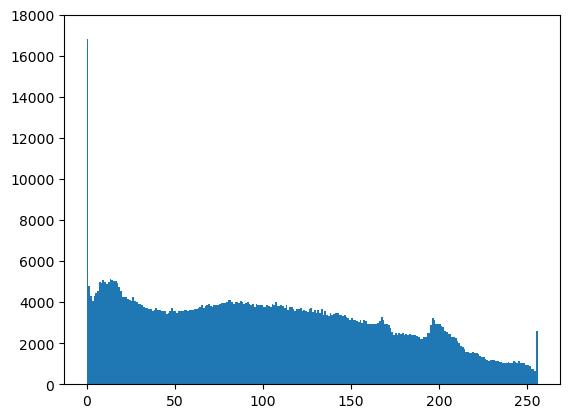

In [33]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

original_image = Image.open(requests.get(image_url, stream=True).raw)
original_image = np.array(original_image)
plt.hist(original_image.ravel(),256,[0,256]);
plt.ylim([0, 18000])
plt.show()

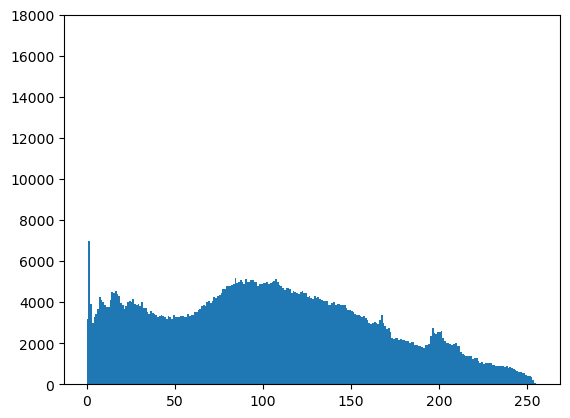

In [39]:
# gaussian filter image

gaussian_filter = cv.GaussianBlur(original_image, (5, 5), 0)
plt.hist(gaussian_filter.ravel(),256,[0,256]); 
plt.ylim([0, 18000])
plt.show()

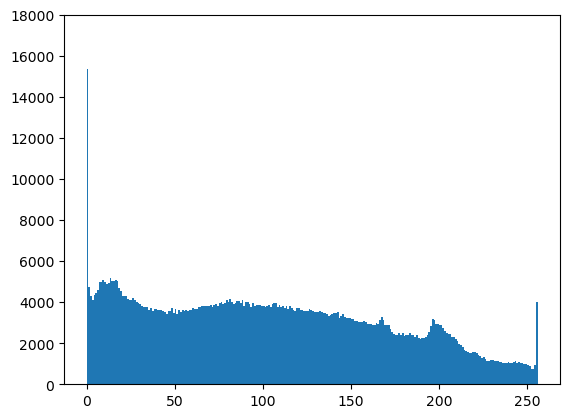

In [35]:
# 3. canny filtered image
edges = cv.Canny(original_image, 100, 200)
edges = edges.reshape(edges.shape[0], edges.shape[1], 1)
canny_image = original_image + edges
plt.hist(canny_image.ravel(),256,[0,256]);
plt.ylim([0, 18000])
plt.show()